In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np
import folium

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
ogdf = pd.read_csv('data/kc_house_data.csv')

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Getting rid of correlated independent variables

In [5]:
test = df.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test['pairs'] = list(zip(test.level_0,test.level_1))
test.set_index(['pairs'], inplace=True)
test.drop(columns=['level_1','level_0'], inplace=True)
test.columns = ['cc']
test.drop_duplicates(inplace=True)

In [6]:
test.sort_values('cc',ascending=False, inplace=True)
test[test.cc >.75]

,cc
pairs,
"(id, id)",1.000000
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [7]:
#dropping sqft above due to correlation with sqft living
df.drop(columns=["sqft_above"], inplace= True)
ogdf.drop(columns=["sqft_above"], inplace= True)

In [8]:
df.reset_index(inplace=True)

In [9]:
df.drop('index',axis=1,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [11]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2810.0        1
475.0         1
704.0         1
248.0         1
295.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [12]:
#replacing ? with 0
df['sqft_basement'] = df.sqft_basement.replace(to_replace= '?', value = '0')
ogdf['sqft_basement'] = ogdf.sqft_basement.replace(to_replace= '?', value = '0')

In [13]:
df.sqft_basement = df.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)
ogdf.sqft_basement = ogdf.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)

In [14]:
#making date datetime format
df['date'] = pd.to_datetime(df['date'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   17755 non-null  float64       
 15  zipcode        2159

In [16]:
#adding column for month
df['month'] = df.date.dt.month

In [17]:
conts = []
cats = []

In [18]:

for col in df.columns:
    if(df[col].nunique() < 25):
        cats.append(col)
    else:
        conts.append(col)

In [19]:
conts.remove('zipcode')

In [20]:
conts

['id',
 'date',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [21]:
cats.append('zipcode')

In [22]:
cats

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month',
 'zipcode']

In [23]:
dfconts = df[conts]
dfconts

,id,date,price,bathrooms,sqft_living,sqft_lot,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,1.00,1180,5650,0,1955,0.0,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,2.25,2570,7242,400,1951,1991.0,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,1.00,770,10000,0,1933,NaN,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,3.00,1960,5000,910,1965,0.0,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,2.00,1680,8080,0,1987,0.0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,2.50,1530,1131,0,2009,0.0,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,2.50,2310,5813,0,2014,0.0,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,0.75,1020,1350,0,2009,0.0,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,2.50,1600,2388,0,2004,0.0,47.5345,-122.069,1410,1287


In [24]:
dfcats = df[cats]

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'zipcode'}>, <AxesSubplot:>]],
      dtype=object)

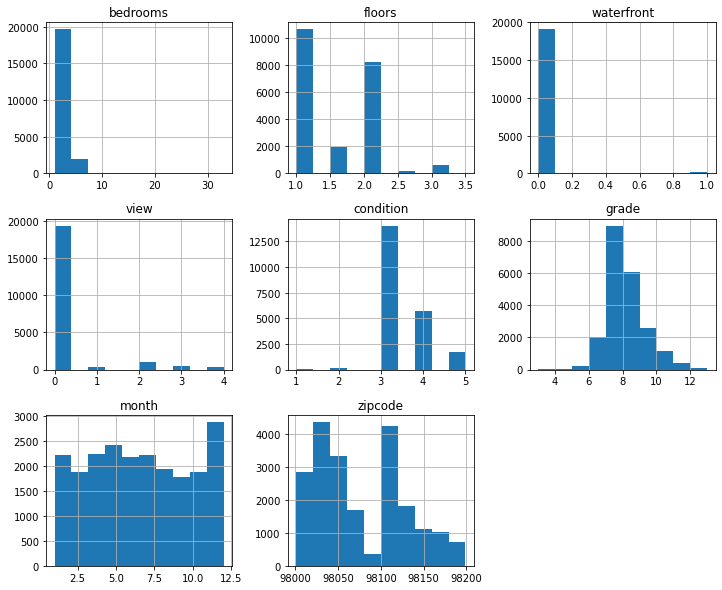

In [25]:
dfcats.hist(figsize=(12,10))

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>]], dtype=object)

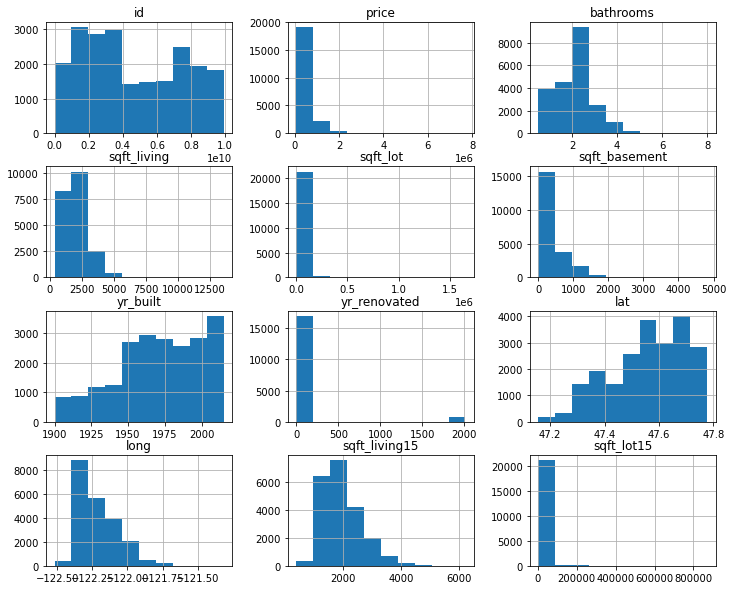

In [26]:
dfconts.hist(figsize=(12,10))

<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

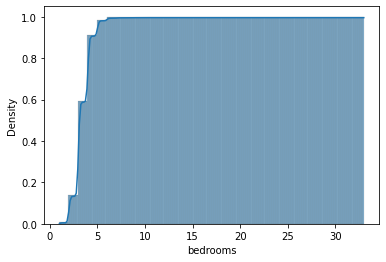

In [27]:
#looks like 90-99% of homes have 10 or less bedrooms
sns.histplot(x='bedrooms',data=dfcats,bins='auto',cumulative=True,stat='density',kde=True)

In [28]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
month               0
dtype: int64

In [29]:
t1 = ogdf

In [30]:
t1['yr_renovated'] = t1['yr_renovated'].apply(lambda x: 1 if (x >0) else x)

In [31]:
t1.yr_renovated.unique()

array([ 0.,  1., nan])

In [32]:
not_renovated = len(t1[t1.yr_renovated == 0])

In [33]:
num_renovated = t1.yr_renovated.sum()
num_renovated

744.0

In [34]:
df['been_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else x)

In [35]:
renovated_weights = list(df.been_renovated.value_counts(normalize=True))


In [36]:
renovated_weights

[0.9580963108983385, 0.041903689101661507]

In [37]:
a = [0,1]
df['been_renovated'] = df['been_renovated'].apply(lambda x: np.random.choice(a,p=renovated_weights) if np.isnan(x) else x)

In [42]:
df.yr_renovated.value_counts(normalize=True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

In [39]:
df.been_renovated.value_counts(normalize=True)

0.0    0.957633
1.0    0.042367
Name: been_renovated, dtype: float64

In [ ]:
### df.rename(columns={"yr_renovated": "been_renovated"},inplace=True)

In [43]:
df.yr_renovated.isna()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2376
view                63
condition            0
grade                0
sqft_basement        0
yr_built             0
yr_renovated      3842
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
month                0
been_renovated       0
dtype: int64

In [53]:
df.dropna(subset=['view'],inplace=True)

In [61]:
ogdf.dropna(subset=['view'],inplace=True)

In [63]:
ogdf.fillna(0, inplace=True)

In [54]:
df.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2370
view                 0
condition            0
grade                0
sqft_basement        0
yr_built             0
yr_renovated      3830
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
month                0
been_renovated       0
dtype: int64

In [ ]:
#titanic.loc[(titanic.Pclass==3) & (titanic.Cabin.isna()), 'Cabin'] = 'B'  

In [55]:
total = 21534
nan = len(ogdf[ogdf.waterfront.isna()])

In [56]:

waterfrontweights = [(1-nan/total),nan/total]
ogdf['waterfront'] = ogdf['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)
df['waterfront'] = df['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)

In [57]:
df.loc[(df.waterfront.isna()) & (df.price > 900000),'waterfront'] =1

In [58]:
df.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_basement        0
yr_built             0
yr_renovated      3830
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
month                0
been_renovated       0
dtype: int64

## Base Model on Original DF

In [64]:
ogdf.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [67]:
outcome = 'price'
x_cols = ogdf.drop(['price', 'id', 'date', 'sqft_living15',], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [68]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

model = ols(formula= f, data= ogdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2984.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:44:06   Log-Likelihood:            -2.9383e+05
No. Observations:               21534   AIC:                         5.877e+05
Df Residuals:                   21517   BIC:                         5.878e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.11e+07   2.93e+06      3.796      0.000    5.37e+06    1.68e+07
bedrooms      -3.768e+04   1928.514    -19.536      0.000   -4.15e+04   -3.39e+04
bathrooms       3.95e+04   3308.239     11.939      0.000     3.3e+04     4.6e+04
sqft_living     191.0893      3.408     56.076      0.000     184.410     197.769
sqft_lot          0.0960      0.049      1.978      0.048       0.001       0.191
floors         7067.2040   3612.533      1.956      0.050     -13.629    1.41e+04
waterfront     1.938e+05   1.04e+04     18.589      0.000    1.73e+05    2.14e+05
view            7.29e+04   2034.704     35.830      0.000    6.89e+04    7.69e+04
condition        2.6e+04   2379.172     10.928      0.000    2.13e+04    3.07e+04
grade          9.968e+04   2099.432     47.482      0.000    9.56e+04    1.04e+05
sqft_basement   -34.9147      4.347     -8.031      0.000     -43.436     -26.394
yr_built      -2634.7761     73.044    -36.071      0.000   -2777.947   -2491.605
yr_renovated   5.232e+04   8042.615      6.505      0.000    3.66e+04    6.81e+04
zipcode        -618.8512     33.354    -18.554      0.000    -684.227    -553.475
lat            6.027e+05   1.09e+04     55.343      0.000    5.81e+05    6.24e+05
long          -2.081e+05   1.32e+04    -15.784      0.000   -2.34e+05   -1.82e+05
sqft_lot15       -0.3535      0.074     -4.755      0.000      -0.499      -0.208
==============================================================================
Omnibus:                    18294.138   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1726999.146
Skew:                           3.585   Prob(JB):                         0.00
Kurtosis:                      46.282   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing sqft basement as has basement

In [141]:
t2 = df.apply(lambda x: x)

In [147]:
t2.sqft_basement = t2.sqft_basement.map(lambda x: 1 if x > 0 else x)

In [153]:
t2.price.std()

366059.58123129635

In [181]:
basement = pd.get_dummies(t2.sqft_basement, prefix='has_basement')

In [182]:
base = pd.concat([t2, basement], axis=1)

In [183]:
base.drop(columns='yr_renovated',inplace=True)

In [184]:
t2[t2.sqft_basement == 1].price.mean()

622264.59802028

In [185]:
outcome = 'price'
x_cols = base.drop(['price', 'id', 'date', 'sqft_living15','month','sqft_basement'], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_lot15', 'been_renovated', 'has_basement_0',
       'has_basement_1'],
      dtype='object')

In [186]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

testb = ols(formula= f, data= base).fit()
testb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2981.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:00:17   Log-Likelihood:            -2.9384e+05
No. Observations:               21534   AIC:                         5.877e+05
Df Residuals:                   21517   BIC:                         5.878e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.165e+06   1.96e+06      3.664      0.000    3.33e+06     1.1e+07
bedrooms       -3.807e+04   1928.352    -19.740      0.000   -4.18e+04   -3.43e+04
bathrooms        4.02e+04   3312.870     12.134      0.000    3.37e+04    4.67e+04
sqft_living      183.7445      3.186     57.673      0.000     177.500     189.989
sqft_lot           0.0922      0.049      1.900      0.057      -0.003       0.187
floors          9746.8069   3077.144      3.167      0.002    3715.376    1.58e+04
waterfront      1.985e+05   1.06e+04     18.745      0.000    1.78e+05    2.19e+05
view            7.173e+04   2022.684     35.464      0.000    6.78e+04    7.57e+04
condition         2.5e+04   2366.663     10.563      0.000    2.04e+04    2.96e+04
grade           1.016e+05   2069.132     49.123      0.000    9.76e+04    1.06e+05
yr_built       -2624.9984     71.170    -36.884      0.000   -2764.497   -2485.500
zipcode         -611.5096     33.409    -18.304      0.000    -676.993    -546.026
lat             6.004e+05   1.09e+04     55.148      0.000    5.79e+05    6.22e+05
long           -2.058e+05   1.32e+04    -15.611      0.000   -2.32e+05    -1.8e+05
sqft_lot15        -0.3436      0.074     -4.622      0.000      -0.489      -0.198
been_renovated  4.046e+04   7222.942      5.602      0.000    2.63e+04    5.46e+04
has_basement_0  3.594e+06   9.77e+05      3.677      0.000    1.68e+06    5.51e+06
has_basement_1  3.571e+06   9.78e+05      3.651      0.000    1.65e+06    5.49e+06
==============================================================================
Omnibus:                    18230.440   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1712836.891
Skew:                           3.565   Prob(JB):                         0.00
Kurtosis:                      46.106   Cond. No.                     7.83e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.55e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Reg on cleaned DF with yr_renovated as binary

In [71]:
outcome = 'price'
x_cols = df.drop(['price', 'id', 'date', 'sqft_living15','month','yr_renovated'], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_lot15', 'been_renovated'],
      dtype='object')

In [72]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

model = ols(formula= f, data= df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2983.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:03:36   Log-Likelihood:            -2.9383e+05
No. Observations:               21534   AIC:                         5.877e+05
Df Residuals:                   21517   BIC:                         5.878e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.084e+07   2.92e+06      3.706      0.000    5.11e+06    1.66e+07
bedrooms       -3.776e+04   1928.697    -19.576      0.000   -4.15e+04    -3.4e+04
bathrooms       3.967e+04   3305.560     12.000      0.000    3.32e+04    4.61e+04
sqft_living      190.8448      3.408     56.001      0.000     184.165     197.524
sqft_lot           0.0886      0.049      1.825      0.068      -0.007       0.184
floors          6672.2101   3612.380      1.847      0.065    -408.323    1.38e+04
waterfront      1.987e+05   1.06e+04     18.771      0.000    1.78e+05    2.19e+05
view            7.286e+04   2035.628     35.792      0.000    6.89e+04    7.69e+04
condition       2.595e+04   2373.508     10.931      0.000    2.13e+04    3.06e+04
grade            9.98e+04   2099.519     47.535      0.000    9.57e+04    1.04e+05
sqft_basement    -34.5941      4.348     -7.957      0.000     -43.116     -26.073
yr_built       -2638.5266     72.569    -36.359      0.000   -2780.766   -2496.287
zipcode         -615.2861     33.359    -18.444      0.000    -680.672    -549.900
lat             6.015e+05   1.09e+04     55.236      0.000     5.8e+05    6.23e+05
long            -2.08e+05   1.32e+04    -15.770      0.000   -2.34e+05   -1.82e+05
sqft_lot15        -0.3459      0.074     -4.653      0.000      -0.492      -0.200
been_renovated  4.096e+04   7224.172      5.670      0.000    2.68e+04    5.51e+04
==============================================================================
Omnibus:                    18295.085   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1735594.987
Skew:                           3.583   Prob(JB):                         0.00
Kurtosis:                      46.393   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model with grade dummies

In [73]:
grade = pd.get_dummies(df['grade'], prefix = 'grade')

In [74]:
dfgrade = pd.concat([df, grade], axis = 1)

In [77]:
outcome = 'price'
x_cols = dfgrade.drop(['price', 'id', 'date','month','grade','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [78]:
modelgrade = ols(formula=f,data = dfgrade).fit()
modelgrade.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     2125.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:05:40   Log-Likelihood:            -2.9272e+05
No. Observations:               21534   AIC:                         5.855e+05
Df Residuals:                   21507   BIC:                         5.857e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.819e+06   2.59e+06      3.399      0.001    3.73e+06    1.39e+07
bedrooms       -2.204e+04   1871.700    -11.774      0.000   -2.57e+04   -1.84e+04
bathrooms       4.306e+04   3156.072     13.644      0.000    3.69e+04    4.92e+04
sqft_living      135.7875      3.675     36.949      0.000     128.584     142.991
sqft_lot           0.1002      0.046      2.169      0.030       0.010       0.191
floors          2.702e+04   3501.082      7.718      0.000    2.02e+04    3.39e+04
waterfront      1.974e+05   1.01e+04     19.620      0.000    1.78e+05    2.17e+05
view            6.669e+04   1961.046     34.009      0.000    6.29e+04    7.05e+04
condition       3.258e+04   2261.579     14.407      0.000    2.81e+04     3.7e+04
sqft_basement     -2.4669      4.235     -0.582      0.560     -10.768       5.834
yr_built       -2178.4511     69.932    -31.151      0.000   -2315.523   -2041.379
zipcode         -612.8704     31.892    -19.217      0.000    -675.382    -550.359
lat             6.152e+05   1.04e+04     59.324      0.000    5.95e+05    6.36e+05
long           -2.117e+05   1.27e+04    -16.679      0.000   -2.37e+05   -1.87e+05
sqft_living15     24.7757      3.351      7.393      0.000      18.207      31.344
sqft_lot15        -0.3617      0.071     -5.116      0.000      -0.500      -0.223
been_renovated  6.051e+04   6879.807      8.795      0.000     4.7e+04     7.4e+04
grade_3         5.265e+05   2.93e+05      1.794      0.073   -4.87e+04     1.1e+06
grade_4         3.554e+05   2.38e+05      1.495      0.135   -1.11e+05    8.21e+05
grade_5         3.434e+05   2.36e+05      1.454      0.146   -1.19e+05    8.06e+05
grade_6         3.643e+05   2.37e+05      1.539      0.124   -9.95e+04    8.28e+05
grade_7         4.019e+05   2.37e+05      1.698      0.089   -6.19e+04    8.66e+05
grade_8         4.605e+05   2.37e+05      1.945      0.052   -3492.344    9.25e+05
grade_9         5.796e+05   2.37e+05      2.445      0.014    1.15e+05    1.04e+06
grade_10        7.448e+05   2.37e+05      3.140      0.002     2.8e+05    1.21e+06
grade_11        9.914e+05   2.38e+05      4.174      0.000    5.26e+05    1.46e+06
grade_12        1.438e+06   2.38e+05      6.038      0.000    9.71e+05     1.9e+06
grade_13        2.614e+06   2.43e+05     10.737      0.000    2.14e+06    3.09e+06
==============================================================================
Omnibus:                    15080.922   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           883752.091
Skew:                           2.751   Prob(JB):                         0.00
Kurtosis:                      33.898   Cond. No.                     2.35e+15
==============================================================================

Notes:
[1] Standard Errors assume t

## Model with view dummies

In [79]:
view = pd.get_dummies(df['view'], prefix = 'v')

In [80]:
view.columns = view.columns.map(lambda x: x.replace('.0',''))

In [81]:
dfview = pd.concat([df, view], axis = 1)

In [82]:
outcome = 'price'
x_cols = dfview.drop(['price', 'id', 'date','month','view','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [83]:
modelview = ols(formula=f, data = dfview ).fit()
modelview.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2451.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:06:01   Log-Likelihood:            -2.9363e+05
No. Observations:               21534   AIC:                         5.873e+05
Df Residuals:                   21513   BIC:                         5.875e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.667e+06   2.46e+06      2.713      0.007    1.85e+06    1.15e+07
bedrooms         -3.7e+04   1911.637    -19.356      0.000   -4.07e+04   -3.33e+04
bathrooms       4.137e+04   3278.085     12.622      0.000    3.49e+04    4.78e+04
sqft_living      180.6434      3.680     49.082      0.000     173.430     187.857
sqft_lot           0.1284      0.048      2.664      0.008       0.034       0.223
floors          9392.5733   3601.566      2.608      0.009    2333.236    1.65e+04
waterfront      1.481e+05   1.09e+04     13.629      0.000    1.27e+05    1.69e+05
condition       2.571e+04   2353.686     10.923      0.000    2.11e+04    3.03e+04
grade           9.674e+04   2172.926     44.518      0.000    9.25e+04    1.01e+05
sqft_basement    -30.9020      4.351     -7.102      0.000     -39.431     -22.373
yr_built       -2672.2141     71.969    -37.130      0.000   -2813.279   -2531.150
zipcode         -589.9801     33.207    -17.767      0.000    -655.069    -524.891
lat             5.938e+05   1.08e+04     54.945      0.000    5.73e+05    6.15e+05
long           -2.157e+05   1.32e+04    -16.293      0.000   -2.42e+05    -1.9e+05
sqft_living15     20.0477      3.471      5.775      0.000      13.244      26.852
sqft_lot15        -0.3632      0.074     -4.925      0.000      -0.508      -0.219
been_renovated  3.869e+04   7166.554      5.398      0.000    2.46e+04    5.27e+04
v_0             1.173e+06   4.91e+05      2.388      0.017     2.1e+05    2.14e+06
v_1             1.286e+06   4.92e+05      2.614      0.009    3.22e+05    2.25e+06
v_2             1.248e+06   4.92e+05      2.539      0.011    2.85e+05    2.21e+06
v_3             1.328e+06   4.92e+05      2.701      0.007    3.64e+05    2.29e+06
v_4             1.632e+06   4.92e+05      3.318      0.001    6.68e+05     2.6e+06
==============================================================================
Omnibus:                    18377.591   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1880800.191
Skew:                           3.584   Prob(JB):                         0.00
Kurtosis:                      48.220   Cond. No.                     5.55e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.08e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

View as dummy values reduces our R2 so will leave as original

## Model with Beds as a categorical

In [88]:
df.bedrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 2.5 , 1.75, 2.75, 1.5 , 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 0.5 , 5.5 , 6.75,
       6.  , 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [89]:
beds = pd.get_dummies(df['bedrooms'], prefix = 'beds')

In [90]:
dfbeds = pd.concat([df, beds], axis = 1)

In [91]:
outcome = 'price'
x_cols = dfbeds.drop(['price', 'id', 'date','month','bedrooms','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [71]:
modelbeds = ols(formula=f, data= dfbeds).fit()
modelbeds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1786.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:26:48   Log-Likelihood:            -2.9375e+05
No. Observations:               21534   AIC:                         5.876e+05
Df Residuals:                   21506   BIC:                         5.878e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9.058e+06   2.74e+06      3.302      0.001    3.68e+06    1.44e+07
bathrooms       4.165e+04   3310.798     12.581      0.000    3.52e+04    4.81e+04
sqft_living      183.2498      3.731     49.114      0.000     175.937     190.563
sqft_lot           0.0961      0.048      1.982      0.047       0.001       0.191
floors          9477.8645   3624.396      2.615      0.009    2373.779    1.66e+04
waterfront      1.781e+05   1.02e+04     17.387      0.000    1.58e+05    1.98e+05
view            7.092e+04   2053.630     34.534      0.000    6.69e+04    7.49e+04
condition       2.811e+04   2375.518     11.834      0.000    2.35e+04    3.28e+04
grade            9.75e+04   2199.641     44.324      0.000    9.32e+04    1.02e+05
sqft_basement    -33.6299      4.380     -7.679      0.000     -42.214     -25.046
yr_built       -2599.0629     72.596    -35.802      0.000   -2741.356   -2456.770
been_renovated  4.906e+04   7157.253      6.855      0.000     3.5e+04    6.31e+04
zipcode         -610.9233     33.437    -18.271      0.000    -676.462    -545.384
lat             5.911e+05   1.09e+04     54.287      0.000     5.7e+05    6.12e+05
long           -2.146e+05   1.33e+04    -16.125      0.000   -2.41e+05   -1.89e+05
sqft_living15     20.9788      3.505      5.985      0.000      14.109      27.849
sqft_lot15        -0.3676      0.074     -4.953      0.000      -0.513      -0.222
beds_1          9.248e+05   2.31e+05      4.006      0.000    4.72e+05    1.38e+06
beds_2          8.795e+05   2.31e+05      3.813      0.000    4.27e+05    1.33e+06
beds_3          8.133e+05    2.3e+05      3.533      0.000    3.62e+05    1.26e+06
beds_4           7.62e+05    2.3e+05      3.310      0.001    3.11e+05    1.21e+06
beds_5           7.69e+05    2.3e+05      3.340      0.001    3.18e+05    1.22e+06
beds_6          7.172e+05    2.3e+05      3.114      0.002    2.66e+05    1.17e+06
beds_7          6.602e+05   2.32e+05      2.842      0.004    2.05e+05    1.12e+06
beds_8          8.697e+05   2.36e+05      3.691      0.000    4.08e+05    1.33e+06
beds_9          6.075e+05   2.42e+05      2.508      0.012    1.33e+05    1.08e+06
beds_10         6.429e+05   2.53e+05      2.543      0.011    1.47e+05    1.14e+06
beds_11         4.905e+05   2.96e+05      1.656      0.098   -9.01e+04    1.07e+06
beds_33         9.213e+05   2.97e+05      3.101      0.002    3.39e+05     1.5e+06
==============================================================================
Omnibus:                    18320.783   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1778588.586
Skew:                           3.584   Prob(JB):                         0.00
Kurtosis:                      46.942   Cond. No.                     2.34e+15
================================

In [72]:
#does imporve R2 slightly but I think grouping would be more productive and easier to understand

## Zipcode dummies model

In [93]:
zipcode = pd.get_dummies(df['zipcode'], prefix = 'zip')
dfzip = pd.concat([df, zipcode], axis = 1)

In [94]:
outcome = 'price'
x_cols = dfzip.drop(['price', 'id', 'date','month','zipcode','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [95]:
modelzipcat = ols(formula=f,data = dfzip).fit()
modelzipcat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     982.7
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:08:12   Log-Likelihood:            -2.8932e+05
No. Observations:               21534   AIC:                         5.788e+05
Df Residuals:                   21448   BIC:                         5.795e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.638e+07   6.26e+06     -4.214      0.000   -3.86e+07   -1.41e+07
bedrooms       -2.956e+04   1587.142    -18.627      0.000   -3.27e+04   -2.65e+04
bathrooms       2.279e+04   2712.741      8.402      0.000    1.75e+04    2.81e+04
sqft_living      208.5977      3.109     67.087      0.000     202.503     214.692
sqft_lot           0.2167      0.040      5.464      0.000       0.139       0.294
floors         -3.937e+04   3238.536    -12.156      0.000   -4.57e+04    -3.3e+04
waterfront       2.18e+05   8652.809     25.200      0.000    2.01e+05    2.35e+05
view            7.595e+04   1722.284     44.100      0.000    7.26e+04    7.93e+04
condition       2.453e+04   1977.737     12.403      0.000    2.07e+04    2.84e+04
grade           5.842e+04   1881.973     31.042      0.000    5.47e+04    6.21e+04
sqft_basement    -75.4123      3.711    -20.322      0.000     -82.686     -68.139
yr_built        -794.2312     65.934    -12.046      0.000    -923.467    -664.995
lat             1.668e+05   6.55e+04      2.546      0.011    3.84e+04    2.95e+05
long           -1.642e+05    4.7e+04     -3.492      0.000   -2.56e+05    -7.2e+04
sqft_living15      6.9112      2.978      2.320      0.020       1.073      12.749
sqft_lot15        -0.1374      0.062     -2.200      0.028      -0.260      -0.015
been_renovated   3.69e+04   5912.318      6.241      0.000    2.53e+04    4.85e+04
zip_98001       -5.43e+05    8.7e+04     -6.243      0.000   -7.13e+05   -3.72e+05
zip_98002      -5.046e+05   8.48e+04     -5.951      0.000   -6.71e+05   -3.38e+05
zip_98003      -5.718e+05   8.89e+04     -6.432      0.000   -7.46e+05   -3.98e+05
zip_98004       1.897e+05   9.15e+04      2.074      0.038    1.04e+04    3.69e+05
zip_98005      -2.743e+05   9.03e+04     -3.039      0.002   -4.51e+05   -9.74e+04
zip_98006       -3.08e+05   8.72e+04     -3.530      0.000   -4.79e+05   -1.37e+05
zip_98007      -3.313e+05   8.94e+04     -3.707      0.000   -5.07e+05   -1.56e+05
zip_98008      -3.129e+05   8.79e+04     -3.559      0.000   -4.85e+05   -1.41e+05
zip_98010      -4.425e+05    7.7e+04     -5.744      0.000   -5.93e+05   -2.91e+05
zip_98011      -4.865e+05   9.62e+04     -5.059      0.000   -6.75e+05   -2.98e+05
zip_98014      -4.365e+05   8.11e+04     -5.385      0.000   -5.95e+05   -2.78e+05
zip_98019      -4.706e+05   8.67e+04     -5.428      0.000   -6.41e+05   -3.01e+05
zip_98022      -5.063e+05   7.37e+04     -6.871      0.000   -6.51e+05   -3.62e+05
zip_98023      -5.897e+05    9.1e+04     -6.481      0.000   -7.68e+05   -4.11e+05
zip_98024      -3.742e+05   7.99e+04     -4.682      0.000   -5.31e+05   -2.18e+05
zip_98027      -3.721e+05   8.21e+04     -4.530      0.000   -5.33e+05   -2.11e+05
zip_98028      -4.951e+05   9.76e+04     -5.071      0.000   -6.87e+05   -3.04e+05
zip_98029   

Train MSE: 27019643967.99005
Test MSE: 28693615859.86552
RMSE Train: 164376.53107420795
RMSE Test: 169391.90021918263


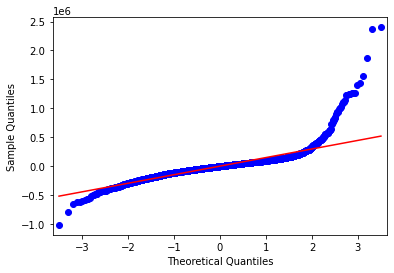

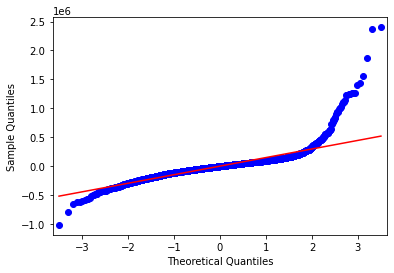

In [97]:
data = dfzip.copy()

y = data['price']
X = data.drop(['price', 'date', 'id', 'zipcode','yr_renovated' ], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

In [195]:
#.10 higher on R2 so thats good need to reduce zip to 4-10 sectors

## Floors as dummy vars

In [98]:
df.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [99]:
df.floors = df.floors.map(lambda x: round(x+.01))

In [100]:
floors = pd.get_dummies(df['floors'], prefix = 'floor')
dffloor = pd.concat([df, floors], axis = 1)

In [102]:
outcome = 'price'
x_cols = dffloor.drop(['price', 'id', 'date','month','floors','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [103]:
modelfloor = ols(formula=f,data = dffloor).fit()
modelfloor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2531.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:09:41   Log-Likelihood:            -2.9377e+05
No. Observations:               21534   AIC:                         5.876e+05
Df Residuals:                   21514   BIC:                         5.877e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.723e+06   2.37e+06      3.255      0.001    3.07e+06    1.24e+07
bedrooms       -3.706e+04   1924.949    -19.254      0.000   -4.08e+04   -3.33e+04
bathrooms       4.166e+04   3283.467     12.688      0.000    3.52e+04    4.81e+04
sqft_living      186.0802      3.726     49.946      0.000     178.778     193.383
sqft_lot           0.0983      0.049      2.027      0.043       0.003       0.193
waterfront      2.002e+05   1.06e+04     18.959      0.000     1.8e+05    2.21e+05
view            7.027e+04   2057.547     34.152      0.000    6.62e+04    7.43e+04
condition        2.55e+04   2369.899     10.760      0.000    2.09e+04    3.01e+04
grade           9.547e+04   2188.126     43.631      0.000    9.12e+04    9.98e+04
sqft_basement    -37.4195      4.418     -8.470      0.000     -46.079     -28.760
yr_built       -2686.7918     71.512    -37.571      0.000   -2826.960   -2546.624
zipcode         -592.8359     33.424    -17.737      0.000    -658.350    -527.322
lat             5.895e+05   1.09e+04     54.017      0.000    5.68e+05    6.11e+05
long           -2.056e+05   1.34e+04    -15.361      0.000   -2.32e+05   -1.79e+05
sqft_living15     21.9158      3.502      6.259      0.000      15.052      28.779
sqft_lot15        -0.3798      0.074     -5.117      0.000      -0.525      -0.234
been_renovated  4.269e+04   7205.475      5.925      0.000    2.86e+04    5.68e+04
floor_1          1.87e+06   5.93e+05      3.155      0.002    7.08e+05    3.03e+06
floor_2         1.862e+06   5.93e+05      3.139      0.002    6.99e+05    3.02e+06
floor_3         1.935e+06   5.94e+05      3.258      0.001    7.71e+05     3.1e+06
floor_4         2.057e+06   5.97e+05      3.445      0.001    8.87e+05    3.23e+06
==============================================================================
Omnibus:                    18412.684   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1790289.872
Skew:                           3.614   Prob(JB):                         0.00
Kurtosis:                      47.080   Cond. No.                     3.21e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

No material change with floor as categorical or with dummy variables so will leave as original

## Model with outliers past 3std dropped

In [128]:
df.been_renovated.value_counts()

0.0    20621
1.0      913
Name: been_renovated, dtype: int64

In [130]:
q,p = df.been_renovated.value_counts(normalize=True)

In [129]:
n = sum(df.been_renovated.value_counts())


In [133]:
n*p*q

874.2905637596359

In [108]:
from scipy import stats
df_zscore = df.drop('date', axis=1)
df_zscore = df[(np.abs(stats.zscore(df_zscore)) < 3).all(axis=1)]

<ipython-input-108-28965e779bd6>:3: RuntimeWarning: invalid value encountered in less
  df_zscore = df[(np.abs(stats.zscore(df_zscore)) < 3).all(axis=1)]


In [121]:
df_zscore = df.drop(['date','yr_renovated'], axis=1)

In [124]:
df_zscore.been_renovated.std()

0.20150026671603066

In [117]:
df_zscore = df_zscore[(np.abs(stats.zscore(df_zscore)) < 3).all(axis=1)]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'cent

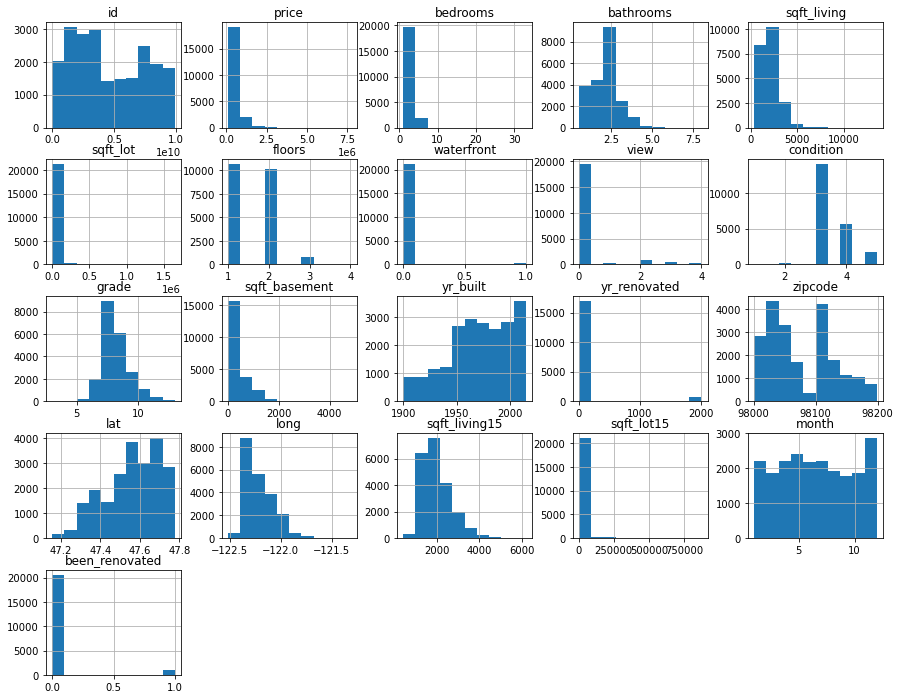

In [105]:
df.hist(figsize=(15,12))

In [118]:
len(df) -  len(df_zscore)

3097

In [86]:
#dropping outliers via zscore removes some 3k rows of data

In [87]:
df_zscore.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'been_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [138]:
outcome = 'price'
x_cols = df_zscore.drop(['price', 'id','month','sqft_living15','sqft_lot15'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [139]:
modelz = ols(formula=f,data = df_zscore).fit()
modelz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     3178.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:41:11   Log-Likelihood:            -2.9384e+05
No. Observations:               21534   AIC:                         5.877e+05
Df Residuals:                   21518   BIC:                         5.878e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.019e+07   2.91e+06      3.497      0.000    4.48e+06    1.59e+07
bedrooms       -3.746e+04   1927.067    -19.438      0.000   -4.12e+04   -3.37e+04
bathrooms       4.006e+04   3286.251     12.191      0.000    3.36e+04    4.65e+04
sqft_living      189.4562      3.399     55.747      0.000     182.795     196.118
sqft_lot          -0.0670      0.035     -1.898      0.058      -0.136       0.002
floors          7144.5380   3175.290      2.250      0.024     920.733    1.34e+04
waterfront      1.985e+05   1.06e+04     18.737      0.000    1.78e+05    2.19e+05
view            7.272e+04   2036.241     35.715      0.000    6.87e+04    7.67e+04
condition       2.578e+04   2373.337     10.863      0.000    2.11e+04    3.04e+04
grade           9.992e+04   2099.448     47.594      0.000    9.58e+04    1.04e+05
sqft_basement    -33.7739      4.329     -7.802      0.000     -42.259     -25.288
yr_built       -2624.2975     71.149    -36.885      0.000   -2763.755   -2484.840
zipcode         -616.6049     33.376    -18.475      0.000    -682.023    -551.186
lat             6.026e+05   1.09e+04     55.356      0.000    5.81e+05    6.24e+05
long           -2.136e+05   1.31e+04    -16.280      0.000   -2.39e+05   -1.88e+05
been_renovated  4.106e+04   7222.815      5.685      0.000    2.69e+04    5.52e+04
==============================================================================
Omnibus:                    18314.720   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1743969.918
Skew:                           3.589   Prob(JB):                         0.00
Kurtosis:                      46.499   Cond. No.                     2.08e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
dfzip2 = pd.concat([df_zscore, zipcode], axis = 1)

In [91]:
outcome = 'price'
x_cols = dfzip2.drop(['price', 'id','date','month','sqft_living15','sqft_lot15','zipcode'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [92]:
modelz = ols(formula=f,data = dfzip2).fit()
modelz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1112.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:11:57   Log-Likelihood:            -2.3724e+05
No. Observations:               18407   AIC:                         4.746e+05
Df Residuals:                   18325   BIC:                         4.753e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.773e+07   5.05e+06     -3.515      0.000   -2.76e+07   -7.84e+06
bedrooms       -5782.3364   1110.688     -5.206      0.000   -7959.389   -3605.284
bathrooms       1.662e+04   1813.442      9.167      0.000    1.31e+04    2.02e+04
sqft_living      145.3012      2.052     70.809      0.000     141.279     149.323
sqft_lot           0.7772      0.073     10.686      0.000       0.635       0.920
floors          -1.75e+04   1834.901     -9.536      0.000   -2.11e+04   -1.39e+04
waterfront      -3.23e-06   9.19e-07     -3.514      0.000   -5.03e-06   -1.43e-06
view             3.81e+04   1842.903     20.672      0.000    3.45e+04    4.17e+04
condition       2.321e+04   1258.704     18.438      0.000    2.07e+04    2.57e+04
grade             5.2e+04   1213.127     42.863      0.000    4.96e+04    5.44e+04
sqft_basement    -59.2228      2.552    -23.207      0.000     -64.225     -54.221
yr_built        -635.8370     41.330    -15.384      0.000    -716.847    -554.827
been_renovated -5.581e-07   1.59e-07     -3.513      0.000   -8.69e-07   -2.47e-07
lat             1.437e+05   4.29e+04      3.352      0.001    5.97e+04    2.28e+05
long            -9.95e+04   4.07e+04     -2.446      0.014   -1.79e+05   -1.98e+04
zip_98001      -4.155e+05   7.26e+04     -5.727      0.000   -5.58e+05   -2.73e+05
zip_98002      -3.962e+05   7.04e+04     -5.628      0.000   -5.34e+05   -2.58e+05
zip_98003       -4.23e+05   7.41e+04     -5.710      0.000   -5.68e+05   -2.78e+05
zip_98004       1.613e+05   7.28e+04      2.216      0.027    1.86e+04    3.04e+05
zip_98005      -1.157e+05   7.16e+04     -1.616      0.106   -2.56e+05    2.47e+04
zip_98006      -1.672e+05      7e+04     -2.390      0.017   -3.04e+05   -3.01e+04
zip_98007        -1.9e+05   7.07e+04     -2.688      0.007   -3.28e+05   -5.15e+04
zip_98008      -2.077e+05   6.96e+04     -2.986      0.003   -3.44e+05   -7.14e+04
zip_98010      -3.096e+05   6.34e+04     -4.885      0.000   -4.34e+05   -1.85e+05
zip_98011      -3.234e+05   7.48e+04     -4.324      0.000    -4.7e+05   -1.77e+05
zip_98014      -3.141e+05   6.42e+04     -4.895      0.000    -4.4e+05   -1.88e+05
zip_98019      -3.495e+05   6.65e+04     -5.260      0.000    -4.8e+05   -2.19e+05
zip_98022      -3.727e+05   6.16e+04     -6.053      0.000   -4.93e+05   -2.52e+05
zip_98023      -4.438e+05   7.61e+04     -5.831      0.000   -5.93e+05   -2.95e+05
zip_98024       -2.72e+05   6.26e+04     -4.347      0.000   -3.95e+05   -1.49e+05
zip_98027      -2.265e+05   6.59e+04     -3.438      0.001   -3.56e+05   -9.73e+04
zip_98028      -3.416e+05   7.63e+04     -4.478      0.000   -4.91e+05   -1.92e+05
zip_98029      -1.999e+05   6.47e+04     -3.087      0.002   -3.27e+05    -7.3e+04
zip_98030      -4.095e+05   6.98e+04     -5.866      0.000   -5.46e+05   -2.73e+05
zip_98031   

From our original dataframe without dropping any rows:


Mean Price of a home is $540,297

Stan Dev of a home is $367,368

## Model with log of continuous values 

In [93]:
def normalize(x):
    return(x - np.mean(x))/ (max(x) - min(x))

In [94]:
df_zscore.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'been_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [95]:
dflog = df_zscore.drop('date',axis=1)
dflog['log_sqft_living'] = np.log(dflog['sqft_living'])


In [100]:
dflog.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,been_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,log_sqft_living,log_sqft_basement,log_sqft_lot,log_sqft_lot15,log_sqft_living15
0,7129300520,221900.0,3,1.00,1180,5650,1,0.0,0.0,3,7,0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,7.073270,0.000000,8.639411,8.639411,7.200425
2,5631500400,180000.0,2,1.00,770,10000,1,0.0,0.0,3,6,0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,6.646391,0.000000,9.210340,8.994917,7.908387
3,2487200875,604000.0,4,3.00,1960,5000,1,0.0,0.0,5,7,910,1965,0.0,98136,47.5208,-122.393,1360,5000,12,7.580700,6.813445,8.517193,8.517193,7.215240
4,1954400510,510000.0,3,2.00,1680,8080,1,0.0,0.0,3,8,0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,7.426549,0.000000,8.997147,8.923058,7.495542
6,1321400060,257500.0,3,2.25,1715,6819,2,0.0,0.0,3,7,0,1995,0.0,98003,47.3097,-122.327,2238,6819,6,7.447168,0.000000,8.827468,8.827468,7.713338


In [99]:
dflog['log_sqft_living'] = np.log(dflog['sqft_living'])
dflog['log_sqft_lot'] = np.log(dflog['sqft_lot'])
dflog['log_sqft_lot15'] = np.log(dflog['sqft_lot15'])
dflog['log_sqft_living15'] = np.log(dflog['sqft_living15'])
dflog['log_sqft_basement'] = dflog['sqft_basement'].apply(lambda x: np.log(x) if x != 0 else x)


In [101]:
outcome = 'price'
x_cols = dflog.drop(['price', 'id','month','sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [102]:
modellogz = ols(formula=f , data = dflog).fit()
modellogz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2469.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:16:08   Log-Likelihood:            -2.4345e+05
No. Observations:               18407   AIC:                         4.869e+05
Df Residuals:                   18391   BIC:                         4.871e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -6.85e+05    2.2e+06     -0.312      0.755   -4.99e+06    3.62e+06
bedrooms          -9793.0964   1569.138     -6.241      0.000   -1.29e+04   -6717.440
bathrooms          3.225e+04   2552.184     12.636      0.000    2.72e+04    3.73e+04
floors             1.927e+04   2560.895      7.524      0.000    1.42e+04    2.43e+04
waterfront         1.773e-08   5.72e-08      0.310      0.756   -9.43e-08     1.3e-07
view               3.965e+04   2550.388     15.546      0.000    3.46e+04    4.46e+04
condition          2.643e+04   1717.082     15.395      0.000    2.31e+04    2.98e+04
grade              9.725e+04   1587.358     61.266      0.000    9.41e+04       1e+05
yr_built          -2298.6638     53.024    -43.351      0.000   -2402.596   -2194.731
been_renovated     5.039e-09   1.58e-08      0.320      0.749   -2.59e-08    3.59e-08
zipcode            -310.6523     24.143    -12.867      0.000    -357.975    -263.329
lat                5.573e+05   7718.504     72.209      0.000    5.42e+05    5.72e+05
long              -5.834e+04   1.08e+04     -5.403      0.000   -7.95e+04   -3.72e+04
log_sqft_living    1.468e+05   5917.359     24.816      0.000    1.35e+05    1.58e+05
log_sqft_basement  -644.6573    414.783     -1.554      0.120   -1457.670     168.355
log_sqft_lot      -3031.9163   3372.198     -0.899      0.369   -9641.738    3577.905
log_sqft_lot15    -1.928e+04   3631.567     -5.310      0.000   -2.64e+04   -1.22e+04
log_sqft_living15  9.807e+04   5415.940     18.107      0.000    8.75e+04    1.09e+05
==============================================================================
Omnibus:                     5339.938   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24076.419
Skew:                           1.352   Prob(JB):                         0.00
Kurtosis:                       7.907   Cond. No.                     5.07e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Train MSE: 18152812939.53624
Test MSE: 17413922136.693714
RMSE Train: 134732.37524639815
RMSE Test: 131961.82075393517


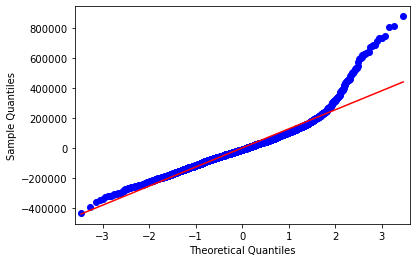

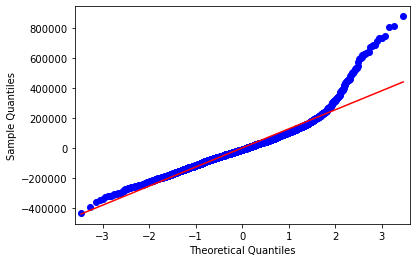

In [103]:
data = dflog.copy()

y = data['price']
X = data.drop(['price', 'id','month','sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

## Model of lognorm for cont values

In [104]:
dflognorm = dflog.apply(lambda x: x*(1))

In [107]:
dflognorm.drop(['sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'],axis=1,inplace=True)

In [144]:
dflognorm['lognorm_sqft_living'] = normalize(dflognorm['log_sqft_living'])

In [137]:

dflognorm['lognorm_sqft_lot'] = normalize(dflognorm['log_sqft_lot'])
dflognorm['lognorm_sqft_lot15'] = normalize(dflognorm['log_sqft_lot15'])
dflognorm['lognorm_sqft_living15'] = normalize(dflognorm['log_sqft_living15'])
dflognorm['lognorm_sqft_basement'] = normalize(dflognorm['log_sqft_basement'])

In [138]:
dflognorm.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'yr_built', 'been_renovated', 'zipcode', 'lat',
       'long', 'month', 'log_sqft_living', 'log_sqft_basement', 'log_sqft_lot',
       'log_sqft_lot15', 'log_sqft_living15', 'lognorm_sqft_lot',
       'lognorm_sqft_lot15', 'lognorm_sqft_living15', 'lognorm_sqft_basement'],
      dtype='object')

In [145]:
outcome = 'price'
x_cols = dflognorm.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [146]:
modellognorm = ols(formula=f , data = dflognorm).fit()
modellognorm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2469.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:42:43   Log-Likelihood:            -2.4345e+05
No. Observations:               18407   AIC:                         4.869e+05
Df Residuals:                   18391   BIC:                         4.871e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.541e+05   2.19e+06      0.436      0.663   -3.33e+06    5.24e+06
bedrooms              -9793.0964   1569.138     -6.241      0.000   -1.29e+04   -6717.440
bathrooms              3.225e+04   2552.184     12.636      0.000    2.72e+04    3.73e+04
floors                 1.927e+04   2560.895      7.524      0.000    1.42e+04    2.43e+04
waterfront             5.884e-08   1.35e-07      0.435      0.663   -2.06e-07    3.24e-07
view                   3.965e+04   2550.388     15.546      0.000    3.46e+04    4.46e+04
condition              2.643e+04   1717.082     15.395      0.000    2.31e+04    2.98e+04
grade                  9.725e+04   1587.358     61.266      0.000    9.41e+04       1e+05
yr_built              -2298.6638     53.024    -43.351      0.000   -2402.596   -2194.731
been_renovated        -7.684e-10   1.66e-09     -0.463      0.644   -4.02e-09    2.49e-09
zipcode                -310.6523     24.143    -12.867      0.000    -357.975    -263.329
lat                    5.573e+05   7718.504     72.209      0.000    5.42e+05    5.72e+05
long                  -5.834e+04   1.08e+04     -5.403      0.000   -7.95e+04   -3.72e+04
lognorm_sqft_lot       -1.69e+04   1.88e+04     -0.899      0.369   -5.38e+04    1.99e+04
lognorm_sqft_lot15    -9.585e+04   1.81e+04     -5.310      0.000   -1.31e+05   -6.05e+04
lognorm_sqft_living15  2.131e+05   1.18e+04     18.107      0.000     1.9e+05    2.36e+05
lognorm_sqft_basement -4756.1262   3060.167     -1.554      0.120   -1.08e+04    1242.085
lognorm_sqft_living    3.748e+05   1.51e+04     24.816      0.000    3.45e+05    4.04e+05
==============================================================================
Omnibus:                     5339.938   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24076.419
Skew:                           1.352   Prob(JB):                         0.00
Kurtosis:                       7.907   Cond. No.                     9.22e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Lognorm + zip dummies 

In [147]:
lognormzip = pd.concat([dflognorm, zipcode], axis = 1)

In [158]:
lognormzip.dropna(inplace=True)

In [159]:
outcome = 'price'
x_cols = lognormzip.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living','zipcode'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [160]:
model8 = ols(formula=f , data = lognormzip).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     996.4
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:50:38   Log-Likelihood:            -2.3789e+05
No. Observations:               18407   AIC:                         4.759e+05
Df Residuals:                   18323   BIC:                         4.766e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.832e+07   5.25e+06     -3.492      0.000   -2.86e+07   -8.04e+06
bedrooms              -4864.1957   1179.879     -4.123      0.000   -7176.869   -2551.523
bathrooms               2.36e+04   1901.518     12.413      0.000    1.99e+04    2.73e+04
floors                -1154.2622   1980.329     -0.583      0.560   -5035.892    2727.368
waterfront             2.109e-06   6.04e-07      3.492      0.000    9.25e-07    3.29e-06
view                   3.557e+04   1922.962     18.498      0.000    3.18e+04    3.93e+04
condition              2.116e+04   1305.958     16.202      0.000    1.86e+04    2.37e+04
grade                  6.034e+04   1254.420     48.103      0.000    5.79e+04    6.28e+04
yr_built               -542.0145     44.801    -12.098      0.000    -629.829    -454.200
been_renovated        -9.385e-07   2.69e-07     -3.490      0.000   -1.47e-06   -4.11e-07
lat                    1.338e+05   4.44e+04      3.012      0.003    4.67e+04    2.21e+05
long                  -1.081e+05   4.23e+04     -2.559      0.010   -1.91e+05   -2.53e+04
lognorm_sqft_lot       1.948e+05   1.42e+04     13.735      0.000    1.67e+05    2.23e+05
lognorm_sqft_lot15    -2.705e+04   1.37e+04     -1.970      0.049    -5.4e+04    -131.334
lognorm_sqft_living15  1.076e+05   9039.361     11.908      0.000    8.99e+04    1.25e+05
lognorm_sqft_basement -3.543e+04   2341.515    -15.129      0.000      -4e+04   -3.08e+04
lognorm_sqft_living      4.7e+05   1.13e+04     41.427      0.000    4.48e+05    4.92e+05
zip_98001              -4.37e+05   7.55e+04     -5.788      0.000   -5.85e+05   -2.89e+05
zip_98002             -3.985e+05   7.32e+04     -5.445      0.000   -5.42e+05   -2.55e+05
zip_98003             -4.453e+05   7.71e+04     -5.777      0.000   -5.96e+05   -2.94e+05
zip_98004              1.425e+05   7.57e+04      1.883      0.060   -5836.020    2.91e+05
zip_98005             -1.349e+05   7.45e+04     -1.812      0.070   -2.81e+05     1.1e+04
zip_98006             -1.841e+05   7.28e+04     -2.529      0.011   -3.27e+05   -4.14e+04
zip_98007             -2.081e+05   7.35e+04     -2.831      0.005   -3.52e+05    -6.4e+04
zip_98008             -2.218e+05   7.23e+04     -3.066      0.002   -3.64e+05      -8e+04
zip_98010             -3.233e+05    6.6e+04     -4.897      0.000   -4.53e+05   -1.94e+05
zip_98011             -3.406e+05   7.78e+04     -4.378      0.000   -4.93e+05   -1.88e+05
zip_98014             -3.278e+05   6.68e+04     -4.905      0.000   -4.59e+05   -1.97e+05
zip_98019             -3.676e+05   6.91e+04     -5.316      0.000   -5.03e+05   -2.32e+05
zip_98022             -3.884e+05   6.41e+04     -6.061      0.000   -5.14e+05   -2.63e+05
zip_98023             -4.636e+05   7.92e+04     -5.855      0.000   -6.19e+05   -3.08e+05
zip_98024             -

Train MSE: 9852455954.933586
Test MSE: 9825101683.23399
RMSE Train: 99259.53835744747
RMSE Test: 99121.65093073253


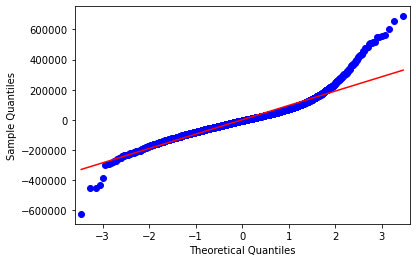

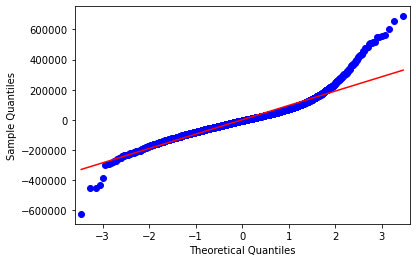

In [164]:
data = lognormzip.copy()

y = data['price']
X = data.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living','zipcode'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

In [1]:
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue = 'zipcode', data=df, palette='Paired')

NameError: name 'plt' is not defined

For Waterfront homes:

Average price of a home is 1,717,215

Std Dev of a house is 1,145,384



In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21534 non-null  int64         
 1   date           21534 non-null  datetime64[ns]
 2   price          21534 non-null  float64       
 3   bedrooms       21534 non-null  int64         
 4   bathrooms      21534 non-null  float64       
 5   sqft_living    21534 non-null  int64         
 6   sqft_lot       21534 non-null  int64         
 7   floors         21534 non-null  float64       
 8   waterfront     21534 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21534 non-null  int64         
 11  grade          21534 non-null  int64         
 12  sqft_basement  21534 non-null  int64         
 13  yr_built       21534 non-null  int64         
 14  yr_renovated   21534 non-null  float64       
 15  zipcode        2153

## Model With Z-Score outliers dropped

In [92]:
df_zscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21534 non-null  int64  
 1   price          21534 non-null  float64
 2   bedrooms       21534 non-null  int64  
 3   bathrooms      21534 non-null  float64
 4   sqft_living    21534 non-null  int64  
 5   sqft_lot       21534 non-null  int64  
 6   floors         21534 non-null  float64
 7   waterfront     21534 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21534 non-null  int64  
 10  grade          21534 non-null  int64  
 11  sqft_basement  21534 non-null  int64  
 12  yr_built       21534 non-null  int64  
 13  yr_renovated   21534 non-null  float64
 14  zipcode        21534 non-null  int64  
 15  lat            21534 non-null  float64
 16  long           21534 non-null  float64
 17  sqft_living15  21534 non-null  int64  
 18  sqft_l

In [ ]:
#group months into seasons or quarters to run together
#could look into when in the month 
np

In [ ]:
#repeat distribution for waterfront variable as well with random choice 

In [94]:
locations = nawater[['lat', 'long']]
locationlist = locations.values.tolist()
locations


,lat,long
0,47.5112,-122.257
10,47.6007,-122.145
23,47.3533,-122.166
40,47.6145,-122.027
55,47.6597,-122.290
...,...,...
21578,47.3749,-122.107
21582,47.2931,-122.264
21586,47.3095,-122.002
21587,47.5389,-121.881


In [95]:
locations.mean()

lat      47.561465
long   -122.213497
dtype: float64

#waterfront`

In [102]:
map = folium.Map(location=[47.5614, -122.257], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=nawater['id']).add_to(map)
map
dff


NameError: name 'dff' is not defined

In [43]:
df.id.duplicated().sum()

177

In [40]:
resold = df[df.id.duplicated(keep=False)].sort_values('id')

In [ ]:
resold

In [98]:
import plotly.express as px

In [ ]:
px.bar(df, x)